In [2]:
"""  Same but with SGD """


'  Same but with SGD '

Class distribution in Train: {'angry': 700, 'happy': 700, 'relaxed': 700, 'sad': 700}
Class distribution in Validation: {'angry': 100, 'happy': 100, 'relaxed': 100, 'sad': 100}
Class distribution in Test: {'angry': 200, 'happy': 200, 'relaxed': 200, 'sad': 200}


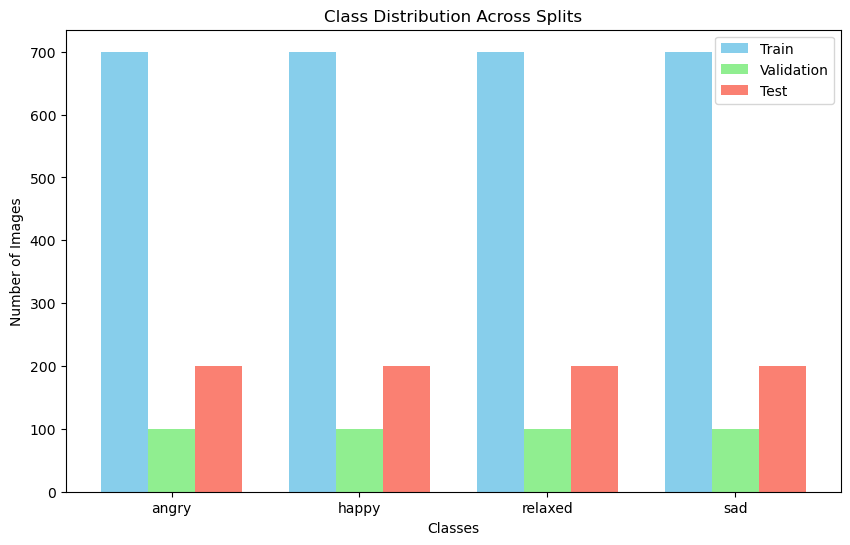

Example images from each class:


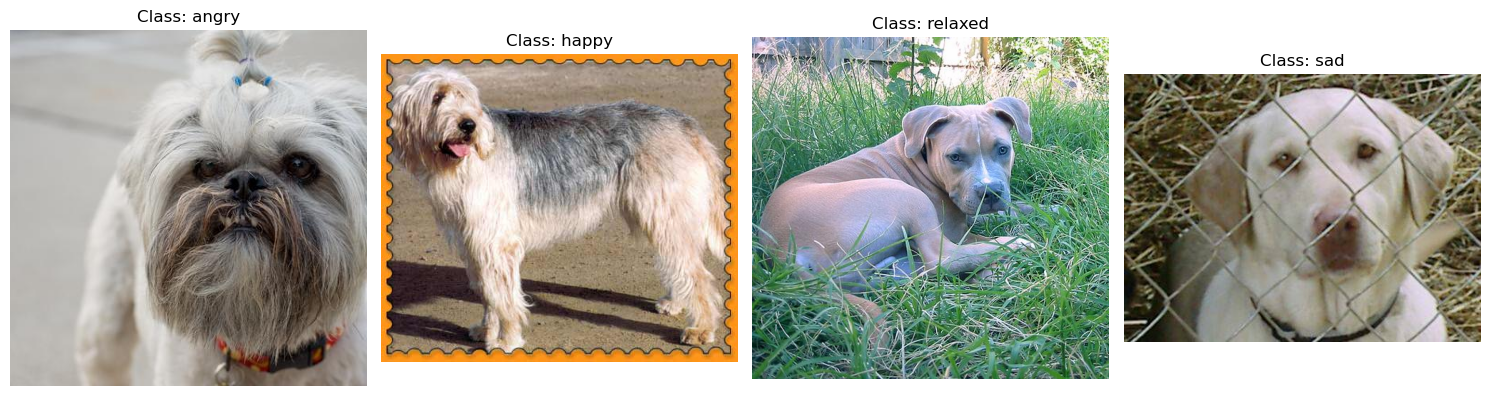

Train set: No corrupted images found.
Validation set: No corrupted images found.
Test set: No corrupted images found.
Analyzing pixel intensity distributions...


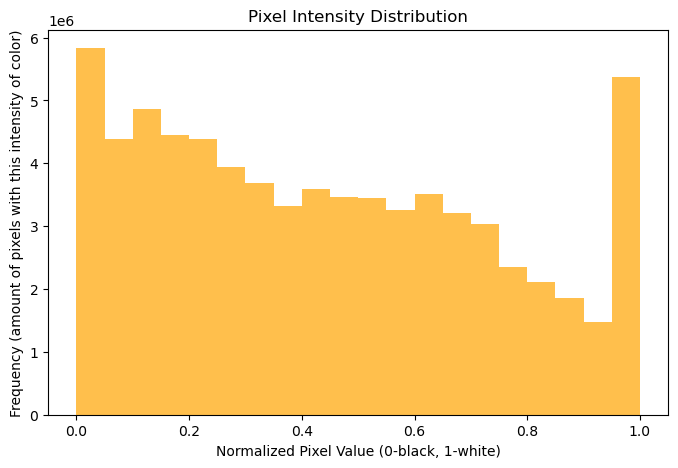

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from collections import Counter
from PIL import Image
import numpy as np

# Paths to dataset
DATA_DIR = "./hw1_data/Dog_Emotion/"

# Transformation for loading images
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load datasets
train_dataset = ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform)
val_dataset = ImageFolder(root=os.path.join(DATA_DIR, "val"), transform=transform)
test_dataset = ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform)

# Function to count images in each class
def count_images(dataset):
    counter = Counter([label for _, label in dataset])
    return {train_dataset.classes[label]: count for label, count in counter.items()}

# Count images in each split
train_counts = count_images(train_dataset)
val_counts = count_images(val_dataset)
test_counts = count_images(test_dataset)

# Print class distributions
print("Class distribution in Train:", train_counts)
print("Class distribution in Validation:", val_counts)
print("Class distribution in Test:", test_counts)

# Combined plot for class distributions
def plot_combined_class_distribution(train_counts, val_counts, test_counts):
    classes = list(train_counts.keys())
    x = np.arange(len(classes))
    width = 0.25

    train_values = [train_counts[cls] for cls in classes]
    val_values = [val_counts[cls] for cls in classes]
    test_values = [test_counts[cls] for cls in classes]

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, train_values, width, label='Train', color='skyblue')
    plt.bar(x, val_values, width, label='Validation', color='lightgreen')
    plt.bar(x + width, test_values, width, label='Test', color='salmon')

    plt.title("Class Distribution Across Splits")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(x, classes)
    plt.legend()
    plt.show()

plot_combined_class_distribution(train_counts, val_counts, test_counts)

# Inspect one example image per class
def inspect_example_images(dataset):
    print("Example images from each class:")
    fig, axs = plt.subplots(1, len(dataset.classes), figsize=(15, 5))

    for cls_idx, cls_name in enumerate(dataset.classes):
        for img_path, label in dataset.imgs:
            if label == cls_idx:
                img = Image.open(img_path)
                axs[cls_idx].imshow(img)
                axs[cls_idx].set_title(f"Class: {cls_name}")
                axs[cls_idx].axis('off')
                break

    plt.tight_layout()
    plt.show()

inspect_example_images(train_dataset)

# Check for corrupted images
def check_corrupted_images(dataset, set_name):
    corrupted = []
    for i, (path, _) in enumerate(dataset.imgs):
        try:
            img = Image.open(path)
            img.verify()  # Verify if the image is not corrupted
        except (IOError, SyntaxError) as e:
            corrupted.append(path)
    if corrupted:
        print(f"{set_name} set: corrupted images are {corrupted}")
    else:
        print(f"{set_name} set: No corrupted images found.")

check_corrupted_images(train_dataset, "Train")
check_corrupted_images(val_dataset, "Validation")
check_corrupted_images(test_dataset, "Test")

# Optional: Analyze pixel intensity distributions
def analyze_pixel_intensity(dataset, num_samples=100):
    print("Analyzing pixel intensity distributions...")
    intensities = []
    for i in range(min(num_samples, len(dataset))):
        img, _ = dataset[i]
        intensities.append(img.numpy().flatten())
    intensities = np.concatenate(intensities)
    
    plt.figure(figsize=(8, 5))
    plt.hist(intensities, bins=20, color='orange', alpha=0.7)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Normalized Pixel Value (0-black, 1-white)")
    plt.ylabel("Frequency (amount of pixels with this intensity of color)")
    plt.show()

analyze_pixel_intensity(train_dataset)


c:\Users\amits\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Train Loss: 8.9213, Train Acc: 0.2522,         Val Loss: 1.4003, Val Acc: 0.2550, best_val_loss: 1.4003, early_stopping_counter: 0,             LR: 0.1
Epoch 2/30, Train Loss: 1.4259, Train Acc: 0.2501,         Val Loss: 1.3956, Val Acc: 0.2500, best_val_loss: 1.3956, early_stopping_counter: 0,             LR: 0.1
Epoch 3/30, Train Loss: 1.3883, Train Acc: 0.2507,         Val Loss: 1.3939, Val Acc: 0.2525, best_val_loss: 1.3939, early_stopping_counter: 0,             LR: 0.1
Epoch 4/30, Train Loss: 1.3885, Train Acc: 0.2469,         Val Loss: 1.3950, Val Acc: 0.2525, best_val_loss: 1.3939, early_stopping_counter: 1,             LR: 0.1
Epoch 5/30, Train Loss: 1.3878, Train Acc: 0.2472,         Val Loss: 1.3671, Val Acc: 0.2500, best_val_loss: 1.3671, early_stopping_counter: 0,             LR: 0.1
Epoch 6/30, Train Loss: 1.3883, Train Acc: 0.2448,         Val Loss: 1.3751, Val Acc: 0.2500, best_val_loss: 1.3671, early_stopping_counter: 1,             LR: 0.1
Epoch 7/30, Trai

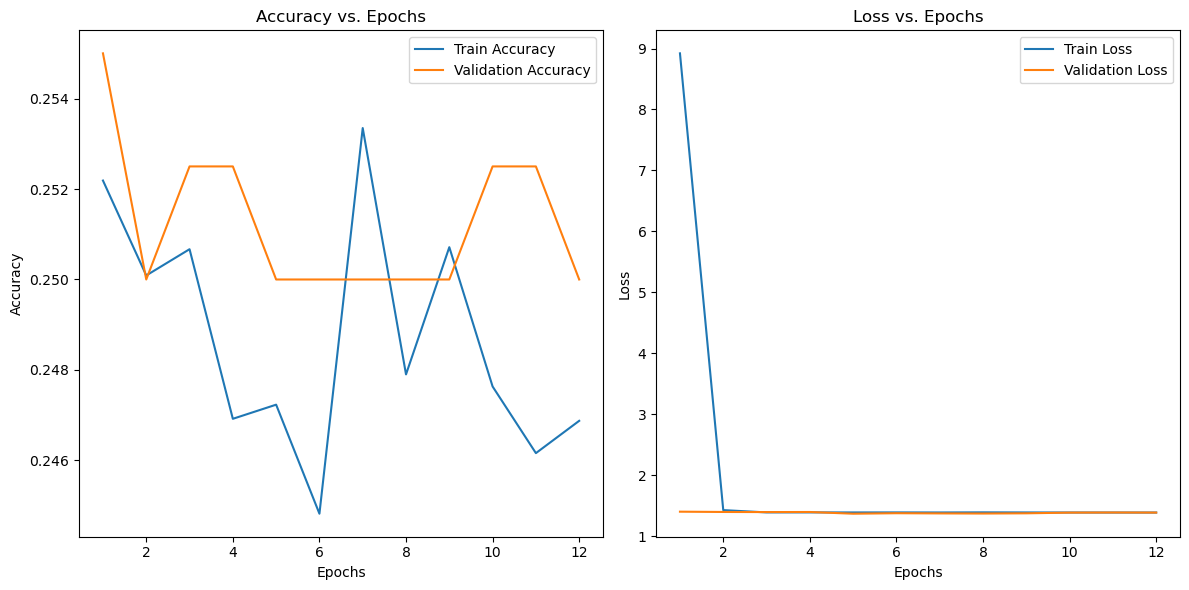

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import random

BATCH_SIZE = 128
IMG_SIZE = 328  # Resize images
EPOCHS = 30
LEARNING_RATE = 0.1
EARLY_STOPPING_PATIENCE = 7

# Custom dataset for augmenting and duplicating images
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, transform=None):
        """
        Augment the dataset with 8 copies of each image using rotation and flipping.
        Args:
            original_dataset: The original dataset.
            transform: Additional transform to apply to the augmented images.
        """
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        # Each image has 8 augmented copies
        return len(self.original_dataset) * 8

    def __getitem__(self, index):
        # Get the original image and label
        original_idx = index // 8  # Determine the original image index
        augmentation_idx = index % 8  # Determine which augmentation to apply
        image, label = self.original_dataset[original_idx]

        # Define the augmentations
        if augmentation_idx < 4:
            # Rotate: 0°, 90°, 180°, or 270°
            angle = augmentation_idx * 90
            image = transforms.functional.rotate(image, angle)
        else:
            # Rotate and then flip horizontally
            angle = (augmentation_idx - 4) * 90
            image = transforms.functional.rotate(image, angle)
            image = transforms.functional.hflip(image)

        # Apply additional transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label
    

def calculate_mean_std(dataset, batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = 0.0
    std = 0.0
    total_images = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples
    mean /= total_images
    std /= total_images
    return mean, std


# Define transforms with updated mean and std
train_initial_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(DATA_DIR + "train", transform=train_initial_transforms)

# Compute mean and std
train_mean, train_std = calculate_mean_std(train_dataset)

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize(mean=train_mean, std=train_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

# Load datasets
train_dataset = AugmentedDataset(train_dataset, transform=train_transforms)
val_dataset = datasets.ImageFolder(DATA_DIR + "val", transform=val_test_transforms)
test_dataset = datasets.ImageFolder(DATA_DIR + "test", transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

""" # Depthwise Separable Convolution Layer
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        # Pointwise convolution (1x1 convolution)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        # Batch Normalization and ReLU activation
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Model Creation
class DogEmotionClassifier(nn.Module):
    def __init__(self):
        super(DogEmotionClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            DepthwiseSeparableConv(3, 16, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            DepthwiseSeparableConv(16, 32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (COMPRESSED_IMG_SIZE // 4) * (COMPRESSED_IMG_SIZE // 4), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x """

# Model Creation
class DogEmotionClassifier(nn.Module):
    def __init__(self):
        super(DogEmotionClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate model
model = DogEmotionClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Pipeline
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=3, verbose=True)

# Logging
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
early_stopping_counter = 0

# def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, best_val_loss, early_stopping_counter):
# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Validation loop
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    # Early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
        print("Early stopping triggered.")
        break

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, \
        Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, best_val_loss: {best_val_loss:.4f}, early_stopping_counter: {early_stopping_counter}, \
            LR: {scheduler.get_last_lr()[0]}")

    scheduler.step(val_losses[-1])

# train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, best_val_loss, early_stopping_counter)

# # After early stopping, use val images as additional training images:
# val_dataset = datasets.ImageFolder(DATA_DIR + "val", transform=train_transforms)
# combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
# combined_train_loader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# train_model(model, combined_train_loader, val_loader, criterion, optimizer, scheduler, device, best_val_loss, early_stopping_counter)


# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

Test Accuracy: 0.2500
Model weights saved to dog_emotion_classifier_2.pkl


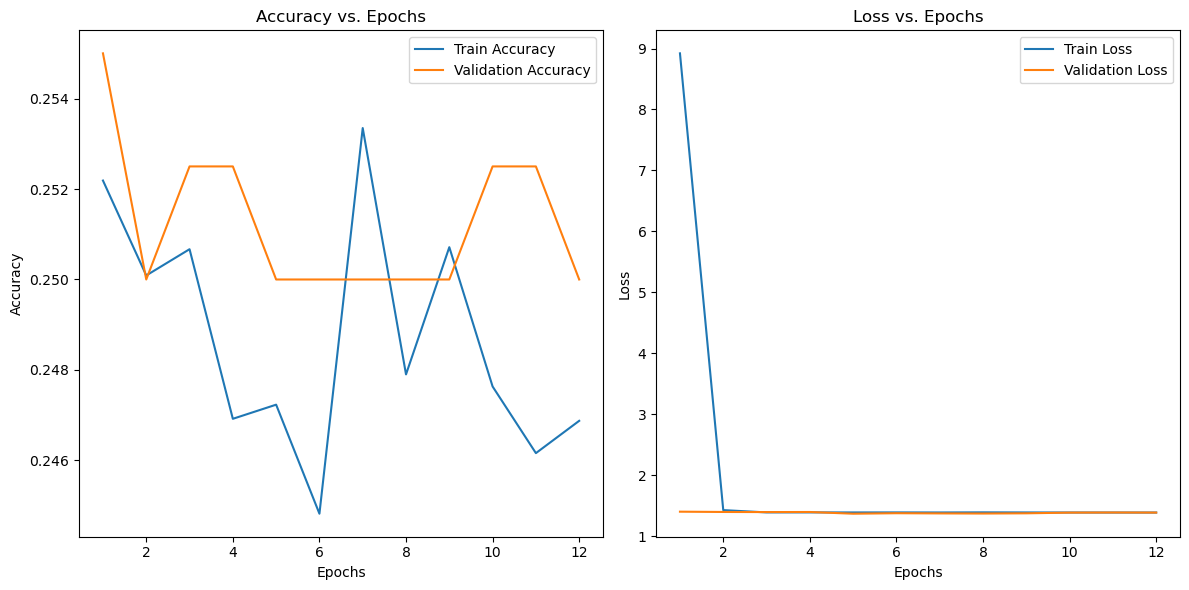

In [5]:
import pickle

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test set evaluation
model.eval()
correct_test, total_test = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save model weights
model_file = "dog_emotion_classifier_2.pkl"
with open(model_file, "wb") as f:
    pickle.dump(model.state_dict(), f)

print(f"Model weights saved to {model_file}")

# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()
